# Project Title

Measuring Public Perception of Apple and Google on Twitter Using Machine Learning

# Phase 1: Business Understanding

## Objective
Build a Natural Language Processing (NLP) model to classify tweets mentioning **Apple** or **Google** into **positive**, **negative**, or **neutral** sentiments. This will help understand public perception, monitor brand reputation, and inform marketing and product strategies.

## Key Questions
- How do people feel about Apple vs Google products on social media?  
- Which words or phrases are most influential in expressing sentiment?  
- Do specific events or product launches trigger changes in sentiment?  

## Business Impact
- **Marketing Strategy:** Adjust campaigns based on trends in sentiment.  
- **Customer Support:** Prioritize responses when negative sentiment spikes.  
- **Product Development:** Identify common issues or requests from user feedback.  
- **Crisis Management:** Detect negative trends early to mitigate PR risks.


# Phase 2: Data Understanding

## Dataset Overview
- **Source:** CrowdFlower via data.world  
- **Total tweets:** ~9,000 (Apple and Google mentions)  
- **Labels:** Positive, Negative, Neutral (human-annotated)  

## Key Columns

| Column | Description | Example |
|--------|-------------|---------|
| `tweet_text` | The content of the tweet | "I love my new iPhone!" |
| `emotion_in_tweet_is_directed_at` | Brand or product mentioned | "iPhone" |
| `is_there_an_emotion_directed_at_a_brand_or_product` | Sentiment label | Positive, Negative, Neutral |


## Dataset Suitability
- Real user opinions, unstructured text  
- Labeled for sentiment → suitable for supervised ML  
- Allows tracking trends over time and across products


##  Importing Required Libraries

In [2]:
# Core & utilities
import time
import re
import joblib
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

# NLP (Natural Language Processing)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Scikit-learn: preprocessing, feature extraction, and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn: metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from xgboost import XGBClassifier

In [3]:
# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Faith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

 Loading the data

In [4]:
df = pd.read_csv("tweets.csv", encoding="latin-1")

 Data Quality Assessment

In [5]:
#Display the first 5 rows of the dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
#Display the names of all available columns in the DataFrame
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [7]:
#Display the number of rows and columns in the dataset
df.shape

(9093, 3)

In [8]:
# getting information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [9]:
df['tweet_text'].head()

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet_text, dtype: object

# Phase 3: Data Cleaning

# 1 Dropping unwanted columns

Remove irrelevant columns such as emotion_in_tweet_is_directed_at that do not add value to the **analysis**

# Display all column names
This helps as understand:

Which columns contain tweet text

Which column is the sentiment label

Which columns are unnecessary

In [10]:
print(df.columns)


Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [11]:
# DROP UNWANTED COLUMNS
# It does not improve sentiment analysis

df.columns = df.columns.str.strip().str.lower()      # normalize column names

df = df.drop(columns=['emotion_in_tweet_is_directed_at'],
             errors='ignore')

# 2 Handling missing values

Drop rows with missing values in the sentiment column.
Fill missing values in other columns with placeholders if necessary.

In [12]:
# Checking Missing Values in each column
df.isnull().sum()


tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [13]:
# HANDLE MISSING VALUES
# To avoid Breaking the model training
# Create wrong predictions

# Drop missing sentiment rows
df = df.dropna(subset=['is_there_an_emotion_directed_at_a_brand_or_product'])


# Fill other missing values
# We replace them with “Unknown” to avoid errors:
# Tf-IDF Does not allow NaN
df.fillna("Unknown", inplace=True)

# 3 Renaming columns and sentiment categories

Rename long column names to shorter, more intuitive ones (e.g., is_there_an_emotion_directed_at_a_brand_or_product → sentiment).
Standardize sentiment labels (No emotion toward brand or product → neutral, etc.).

The sentiment column name is too long and hard to type

Code becomes messy

Models prefer simple, readable column names

In [14]:
# RENAME COLUMNS + STANDARDIZE SENTIMENT LABELS

df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'},
          inplace=True)

# Inspect Sentiment Values
print(df['sentiment'].unique())



['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]


# We notice

Some labels are UPPERCASE, some lowercase

Some have spaces like "negative Emotion "

“I can’t tell” is NOT useful for model training

“No emotion…” is too long

In [15]:
#Why standardize sentiment
# For Consistency,Easier coding,Better accuracy
# First convert to lowercase
df['sentiment'] = df['sentiment'].astype(str).str.lower().str.strip()
# Replace long labels with cleaner ones:
df['sentiment'] = df['sentiment'].replace({
    'no emotion toward brand or product': 'neutral',
    'positive emotion': 'positive',
    'negative emotion': 'negative',
    "i can't tell": 'unknown'
})

# 4 Removing unwanted categories

Drop rows where the sentiment is I can't tell since it does not provide useful information for the model.

In [16]:
# Chech which cell is empty
# df.isnull().sum()
# If a cell is empty, it marks it as True(missing)
# If it is not empty, it marks it as False(not missing)

# STEP 4: REMOVE UNWANTED CATEGORIES
df = df[df['sentiment'] != 'unknown']

# 5 Cleaning text data

Convert text to lowercase.
Remove URLs, numbers, punctuation, and extra spaces.
Ensure the text is consistent and ready for vectorization.

In [17]:
#Raw text from tweets is messy
#URLs like http://...
#Mentions like @username
#Hashtags like #happy
#Numbers, punctuation, extra spaces
print(df['tweet_text'].head())


0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet_text, dtype: object


In [18]:

# CLEAN TEXT DATA
# Define a cleaning function

def clean_text(text):
    text = str(text).lower()

    text = re.sub(r'http\S+|www\S+', '', text)     # remove URLs
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)      # remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)      # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)            # remove punctuation + numbers
    text = re.sub(r'\s+', ' ', text).strip()        # remove extra spaces

    return text
#Apply cleaning function
df['text_clean'] = df['tweet_text'].apply(clean_text)

# Remove stopwords
#Stopwords like “the”, “is”, “at” don’t help the model.
stop_words = set(stopwords.words('english'))
df['text_clean'] = df['text_clean'].apply(
    lambda x: ' '.join([w for w in x.split() if w not in stop_words])
)

# Tokenize
# Split each tweet into words (tokens) for further processing:
df['tokens'] = df['text_clean'].apply(word_tokenize)

# Lemmatize
#Convert words to their root form, e.g., “running” → “run”
lemmatizer = WordNetLemmatizer()
df['tokens_lemmatized'] = df['tokens'].apply(
    lambda t: [lemmatizer.lemmatize(w) for w in t]
)

# Rebuild final text
# After lemmatization, join tokens back into a clean string for vectorization:
df['text_final'] = df['tokens_lemmatized'].apply(lambda t: " ".join(t))


# 6 Text vectorization

Transform the cleaned text into numerical format using techniques like:
Bag of Words (CountVectorizer) Counts how many times each word appears in a document

TF-IDF (TfidfVectorizer)  Counts words but reduces weight of common words across all documents


 Because Machine learning models cannot work directly with text.
 
 
Vectorization converts cleaned text into numbers that a model can understand.

In [19]:
# TEXT VECTORIZATION

# Bag of Words
#Creates a vocabulary of all words in the dataset
#Counts how many times each word appears in each tweet
#Returns a sparse matrix (numerical format)
bow = CountVectorizer()
X_bow = bow.fit_transform(df['text_final'])

# TF-IDF (recommended)
#Words that appear in many tweets (like "love", "product") get lower weight
#Words that are rare but important get higher weight
#Makes features more meaningful for classification
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['text_final'])


# Features and labels
# X → what the model uses to learn patterns
# y → what the model tries to predict (positive/neutral/negative)

X = X_tfidf # Features (numerical representation of text)
y = df['sentiment']#Target labels



In [20]:
# Chicking the final output
print(df[['tweet_text', 'sentiment', 'text_final']].head())
print("\nSentiment distribution:\n", y.value_counts())

                                          tweet_text sentiment  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...  negative   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  positive   
2  @swonderlin Can not wait for #iPad 2 also. The...  positive   
3  @sxsw I hope this year's festival isn't as cra...  negative   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...  positive   

                                          text_final  
0  g iphone hr tweeting dead need upgrade plugin ...  
1  know awesome ipadiphone app youll likely appre...  
2                                     wait also sale  
3     hope year festival isnt crashy year iphone app  
4  great stuff fri marissa mayer google tim oreil...  

Sentiment distribution:
 neutral     5389
positive    2978
negative     570
Name: sentiment, dtype: int64


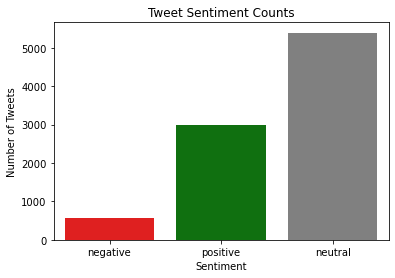

In [21]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette={'neutral':'gray', 'positive':'green', 'negative':'red'})
plt.title('Tweet Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


## Interpretation of Tweet Sentiment Counts (Bar Chart)

- **Neutral (5,500 tweets):**  
  The majority of tweets are neutral, indicating that most users are either sharing information or not expressing strong opinions about Apple or Google products.

- **Positive (3,000 tweets):**  
  A significant portion of tweets show favorable sentiment, reflecting user satisfaction or approval.

- **Negative (600 tweets):**  
  Only a small fraction of tweets are negative, suggesting limited dissatisfaction expressed on Twitter.


 Indeed The bar chart confirms that the majority of users are neutral or positive, with negative reactions being minimal. This insight can guide marketing and customer engagement strategies to maintain positive sentiment while monitoring negative feedback for potential improvements.

# Analyzing Tweet Lengths by Sentiment 


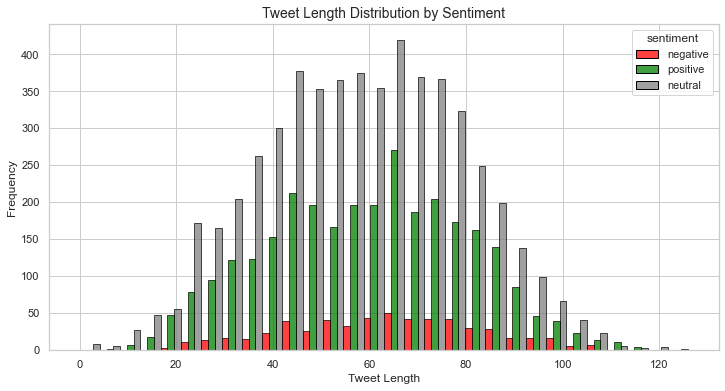

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure tweet text is string and drop missing values
df['text_final'] = df['text_final'].dropna().astype(str)

# Create a new column with tweet lengths
df['tweet_length'] = df['text_final'].str.len()

# Set plot style
sns.set(style="whitegrid")

# Define custom colors for each sentiment
custom_palette = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}

# Plot histogram of tweet lengths by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='tweet_length',
    hue='sentiment',        # Different colors for each sentiment
    bins=30,
    palette=custom_palette,   # Apply custom colors
    multiple='dodge',       # Show side-by-side bars for comparison
    edgecolor='black'
)

# Add labels and title
plt.xlabel('Tweet Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Tweet Length Distribution by Sentiment', fontsize=14)
plt.show()


### Interpretation of Tweet Length Distribution by Sentiment

The histogram above shows how tweet lengths vary across different sentiment categories: **positive**, **negative**, and **neutral**.

**Positive Tweets:**  
These tweets tend to have moderate to slightly longer lengths, mostly between 50 and 100 characters.  
This suggests that users expressing positive emotions often write a bit more, possibly sharing detailed feedback, praise, or experiences.

**Negative Tweets:**  
Negative tweets are generally shorter, clustering around 20 to 80 characters.  
This indicates that users expressing dissatisfaction often post brief, direct messages, likely reflecting frustration or immediate reactions.

**Neutral Tweets:**  
Neutral tweets show a broader range of lengths, including some of the longest tweets in the dataset.  
These are likely factual, informational, or descriptive messages that require more words to convey context without conveying emotion.

**Overall Patterns:**  
- Positive and neutral tweets are generally longer than negative ones.  
- Negative tweets are concise, often signaling quick reactions or complaints.  

This insight can be useful for **feature engineering**, as tweet length might help predict sentiment when combined with other text-based features.




# Phase 4 ;Modeling

## Model 1  Logistic Regression (Baseline)

**Why Logistic Regression?**  
Handles Multiclass Problems (negative, neutral, positive)

Trains and predicts quickly

Works great with text data(TF-IDF)( "great", "amazing" → positive weight)( "terrible", "worst" → negative weight)

Has built-in regularization to prevent overfitting

Interpretable results

Handles Imbalanced Data

Probability outputs

**What we do in this cell:**  
- Build a pipeline that applies TF-IDF to the preprocessed text (`text_final`) and standard scales numeric features (tweet length, word count, etc.).  
- Use `StratifiedKFold` cross-validation with `GridSearchCV` to tune regularization strength (`C`) and penalty.  
- Evaluate on a stratified hold-out test set using `f1_macro` (robust to class imbalance).  
- Save the best LR model for later comparison.

SENTIMENT PREDICTION WITH TEXT + NUMERIC FEATURES

 1. STEP 1: Create Numeric Features
 
 
Negative tweets might be shorter and angrier: "This sucks!"
Positive tweets might be longer with more enthusiasm: "I absolutely love this amazing product!!!"

In [23]:

#Counting how many characters are in each tweet
#Counting how many words are in each tweet

df['tweet_length'] = df['text_final'].str.len()
df['num_words'] = df['text_final'].str.split().map(len)

numeric_features = ['tweet_length', 'num_words']



2 Prepare the Data

X = "What the model sees"

y = "What the model should predict"

In [24]:
# X = our input features (text + numbers)
# y = what we want to predict (sentiment labels)
X = df[['text_final'] + numeric_features]
y = df['sentiment']  # Keep as text labels (negative/neutral/positive)

 3 Split Data into Training & Testing


You can't test a student using the same questions they studied from!
We need "unseen" data to see if the model truly understands


In [25]:

# We trained on 80% of data, tested on 20% to see if model works on NEW data
# stratify=y ensures we keep the same proportion of each sentiment in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

4. Build Preprocessing Pipeline 
Why Pipeline ?


Converts text to numbers (models only understand numbers)
Scales features equally (prevents bias toward large numbers)
Automates everything (one command does all preprocessing)
Prevents mistakes (no data leakage, consistent processing)
Makes code clean (easy to read, maintain, deploy)
Works with GridSearchCV (proper cross-validation)


In [26]:

#Text and numbers need different processing:
#Text: Convert to TF-IDF vectors (finds important words)
#Numbers: Scale to similar ranges (StandardScaler)
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english'),
     'text_final'),  # Process text column
    ('num', StandardScaler(), numeric_features)  # Process numeric columns
])


5: Create the Full Pipeline

Combines everything into ONE object:

First: Preprocess the data (TF-IDF + scaling)
Then: Feed it to Logistic Regression





In [27]:
#class_weight='balanced' → Handles imbalanced data (if you have 100 positive but only 10 negative tweets, this makes sure the model doesn't ignore negatives)
#solver='saga' → The algorithm used to find the best model
#max_iter=2000 → Try up to 2000 times to find the best solution
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(solver='saga',
                               max_iter=2000,
                               class_weight='balanced',  # Handles imbalanced data
                               random_state=42))
])

6. Hyperparameter Tuning

We don't know the BEST settings, so we try different combinations! What's C?

Regularization strength (prevents overfitting) Small C (0.01) → Simple model, might underfit Large C (5) → Complex model, might overfit We're testing: 0.01, 0.1, 1, and 5

In [ ]:
#l1 → Makes some features exactly zero (feature selection)
#l2 → Shrinks all features a little bit
#We're testing both
#Total combinations: 4 C values × 2 penalties = 8 combinations

param_grid = {
    'clf__C': [0.01, 0.1, 1, 5],
    'clf__penalty': ['l1', 'l2']
}

# 5-fold cross-validation: splits training data into 5 parts,
# trains on 4, validates on 1, repeats 5 times
#More reliable than a single train/test split Ensures the model works 
#well on different subsets of data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV tries all combinations and picks the best
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='f1_macro',  # Metric that treats all classes equally
    cv=cv,
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)

7. Train The Model 


In [ ]:

grid.fit(X_train, y_train)

 8. Get best model and predict
 
 Retrieves the winning model (C=5, penalty=l2)
Uses it to predict sentiments on the TEST set (the 20% we held back)


In [ ]:

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

 9.Evaluate The Performance 
 

In [ ]:

print("=" * 60)
print("BEST MODEL RESULTS")
print("=" * 60)
print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV F1 Score: {grid.best_score_:.4f}")
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test Macro F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred))


10.Visualize Confusion Matrix  

Shows where the model makes mistakes
Diagonal = correct predictions
Off-diagonal = mistakes (e.g., predicted positive but was negative)


In [ ]:

# Get sentiment labels in sorted order for consistent display
sentiment_labels = sorted(y.unique())

# Create confusion matrix with explicit label ordering
cm = confusion_matrix(y_test, y_pred, labels=sentiment_labels)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_labels,  # FIXED: Show actual sentiment names
            yticklabels=sentiment_labels)  # FIXED: Show actual sentiment names
plt.xlabel("Predicted Sentiment", fontsize=12)
plt.ylabel("True Sentiment", fontsize=12)
plt.title("Confusion Matrix — Logistic Regression\n(Test Set Performance)", fontsize=14)
plt.tight_layout()
plt.show()


#  ANALYZE RESULTS 
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"Total test samples: {len(y_test)}")
print(f"Correct predictions: {(y_test == y_pred).sum()}")
print(f"Incorrect predictions: {(y_test != y_pred).sum()}")
print("\nPer-class breakdown:")
for label in sentiment_labels:
    count = (y_test == label).sum()
    correct = ((y_test == label) & (y_pred == label)).sum()
    print(f"  {label}: {correct}/{count} correct ({correct/count*100:.1f}%)")

# MODEL 2 — Random Forest Classifier (TF-IDF + Numeric Features)

Why Random Forest?

Handles nonlinear patterns

Works well with mixed features (TF-IDF + numeric)

More robust to noise

Naturally reduces overfitting via bagging

Step 1: Encode Sentiment Labels

Random Forest cannot work with text labels (“positive”, “neutral”, “negative”).
We convert them into numbers using LabelEncoder():

negative → 0

neutral → 1

positive → 2



Because Random Forest only understands numbers, not text.

In [ ]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)   # Convert training labels
y_test_enc = le.transform(y_test)         # Convert test labels

2: Apply the SAME Preprocessor (TF-IDF + Scaling)

We must use the same text+numeric preprocessing that Logistic Regression used, to make results comparable.



Converts text into TF-IDF vectors

Standardizes numeric features (tweet_length, num_words)

Ensures RF model sees the same transformed features

In [ ]:
# Transform text + numeric features
preprocessor.fit(X_train)                # Learn vocabulary + scalers

X_train_tfidf = preprocessor.transform(X_train)   # Apply transformations
X_test_tfidf = preprocessor.transform(X_test)


3: Initialize Random Forest Model

We create a Random Forest with:

200 trees (n_estimators=200)

class_weight='balanced' (fixes class imbalance)

random_state=42 (reproducibility)

n_jobs=-1 (use all CPU cores)



It builds many decision trees and averages them → more stable predictions.

In [ ]:
# Initialize Random Forest model 

rf_classifier = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    random_state=42,
    class_weight='balanced', # Helps handle imbalanced classes
    n_jobs=-1               # Use all CPU cores
)


4: Train the Model

We train Random Forest on the transformed training data.



Each tree learns patterns in TF-IDF + numeric features

Model learns what words/sentences correspond to each sentiment

In [ ]:
# Train the model 
rf_classifier.fit(X_train_tfidf, y_train_enc)


5: Make Predictions

We ask the model to predict sentiments for the test set.


To check how well it performs on data it has never seen before.

In [ ]:
# Predictions on test data 
y_pred_rf = rf_classifier.predict(X_test_tfidf)


6: Evaluate the Model

We calculate:

Accuracy

Macro F1 score

Detailed classification report
(precision, recall, f1 for each class)

Macro F1 = best metric for imbalanced sentiment data

In [ ]:
#  Evaluation 


acc_rf = accuracy_score(y_test_enc, y_pred_rf)
f1_rf = f1_score(y_test_enc, y_pred_rf, average='macro')

print(f"\nRandom Forest Test Accuracy: {acc_rf:.4f}")
print(f"Random Forest Macro F1 Score: {f1_rf:.4f}")

print("\nClassification Report — Random Forest:\n")
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))


7: Confusion Matrix Visualization

Helps you see:

How many correct predictions (diagonal)

Where the model confuses classes (off-diagonal)

In [ ]:
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix — Random Forest (Test Set)")
plt.tight_layout()
plt.show()

#  ANALYZE RESULTS 
print("\n" + "="*60)
print("INTERPRETATION — Random Forest")
print("="*60)

print(f"Total test samples: {len(y_test_enc)}")
print(f"Correct predictions: {(y_test_enc == y_pred_rf).sum()}")
print(f"Incorrect predictions: {(y_test_enc != y_pred_rf).sum()}")

print("\nPer-class breakdown:")
for idx, label in enumerate(le.classes_):
    total = (y_test_enc == idx).sum()
    correct = ((y_test_enc == idx) & (y_pred_rf == idx)).sum()
    print(f"  {label}: {correct}/{total} correct ({correct/total*100:.2f}%)")


# MODEL 3 — SVM(Support Vector Machine) CLASSIFIER (Linear SVM)

1: Transform Features (Already Done)
We have already created in the previous model:

X_train_tfidf

X_test_tfidf

y_train_enc

y_test_enc
    

2: Initialize the SVM Model

We create a Linear SVM using:

kernel='linear':
Best for text classification and high-dimensional TF-IDF data.

class_weight='balanced':
Helps when some classes have fewer samples.

random_state=RANDOM_STATE:
Ensures reproducible results.

Linear SVM work best for text because text datasets have many features (10k–100k words) and SVM works extremely well in high-dimensional spaces.

In [ ]:
# Initialize SVM model 

svm_classifier = SVC(
    kernel='linear',        # Best choice for text data
    class_weight='balanced',# Fix class imbalance
    random_state=RANDOM_STATE
)


3: Train the Model

We train the SVM using the training TF-IDF features.



SVM will finds the best separating hyperplane.

It tries to maximize the margin between sentiment classes.

Works extremely well for separating text patterns.

In [ ]:
#Train the model 
svm_classifier.fit(X_train_tfidf, y_train_enc)


4 Make Predictions

Use the trained SVM to predict sentiments for the test set.


To see how well the model generalizes to unseen tweets.

In [ ]:
#Make  Predictions
y_pred_svm = svm_classifier.predict(X_test_tfidf)


5 Evaluate the Model

In [ ]:
#Evaluation 
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc_svm = accuracy_score(y_test_enc, y_pred_svm)
f1_svm = f1_score(y_test_enc, y_pred_svm, average='macro')

print(f"\nSVM Test Accuracy: {acc_svm:.4f} | Macro F1: {f1_svm:.4f}\n")
print("Classification Report (SVM):\n")
print(classification_report(y_test_enc, y_pred_svm, target_names=le.classes_))


# --- Step 6: Confusion Matrix ---


cm_svm = confusion_matrix(y_test_enc, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — SVM (Test set)')
plt.tight_layout()
plt.show()

#  ANALYZE RESULTS 
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"Total test samples: {len(y_test)}")
print(f"Correct predictions: {(y_test == y_pred).sum()}")
print(f"Incorrect predictions: {(y_test != y_pred).sum()}")
print("\nPer-class breakdown:")
for label in sentiment_labels:
    count = (y_test == label).sum()
    correct = ((y_test == label) & (y_pred == label)).sum()
    print(f"  {label}: {correct}/{count} correct ({correct/count*100:.1f}%)")